In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import Sastrawi
import nltk
import re

nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# load dataset
file_path = '/content/gpt_review.csv'
dt = pd.read_csv(file_path)
dt.head()

,content,score
0,oke,5
1,sangat membantu aku senang menggunakan aplikas...,5
2,"Kok skrng gak bisa ngasih jwbn? Tulisan nya ""m...",1
3,Aplikasi yang membantu,5
4,aplikasi ini bagus,5


In [4]:
len(dt)

20000

In [5]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [6]:
dt.isnull().sum()

,0
content,0
score,0


In [7]:
dt.duplicated().sum()

np.int64(7549)

In [8]:
dt.drop_duplicates(subset='content', inplace=True)

In [9]:
len(dt)

12178

In [10]:
# cleaning dataset
def clean(text):
  text = str(text).lower() # ubah ke lowercase
  text = re.sub(r'https?://\S+', '', text) # hapus url
  text = re.sub(r'#\w+', '', text) # hapus hashtags
  text = re.sub(r'@\w+', '', text) # hapus mentions
  text = re.sub(r'[^\w\s]', '', text) # hapus tanda baca
  text = re.sub(r'\d+', '', text) # hapus angka
  text = re.sub(r'\s+', ' ', text) # hapus spasi ganda
  text = text.strip() # hapus spasi di awal dan akhir
  text = re.sub(r'[^A-Za-z0-9\s]', '', text) # hapus karakter non-alfanumerik
  text = re.sub(r'\b\w{1,2}\b', '', text) # hapus kata pendek
  return text

# terapkan ke kolom konten
dt['clean_content'] = dt['content'].apply(clean)
dt[['content', 'clean_content']].head()

,content,clean_content
0,oke,oke
1,sangat membantu aku senang menggunakan aplikas...,sangat membantu aku senang menggunakan aplikas...
2,"Kok skrng gak bisa ngasih jwbn? Tulisan nya ""m...",kok skrng gak bisa ngasih jwbn tulisan nya maa...
3,Aplikasi yang membantu,aplikasi yang membantu
4,aplikasi ini bagus,aplikasi ini bagus


In [11]:
dt.head()

,content,score,clean_content
0,oke,5,oke
1,sangat membantu aku senang menggunakan aplikas...,5,sangat membantu aku senang menggunakan aplikas...
2,"Kok skrng gak bisa ngasih jwbn? Tulisan nya ""m...",1,kok skrng gak bisa ngasih jwbn tulisan nya maa...
3,Aplikasi yang membantu,5,aplikasi yang membantu
4,aplikasi ini bagus,5,aplikasi ini bagus


In [12]:
len(dt)

12178

In [13]:
# filter panjang kata
def filter_length(dt, column, min_length, max_length):
  word_count = dt[column].apply(lambda x: len(str(x).split()))
  filtered_dt = dt[(word_count >= min_length) & (word_count <= max_length)]
  return filtered_dt

In [14]:
dt = filter_length(dt, 'clean_content', 2, 50)

In [15]:
len(dt)

10671

In [16]:
# inisialisasi stemmer
stemmer = StemmerFactory().create_stemmer()
stopwords_remover = StopWordRemoverFactory().create_stop_word_remover()

# normalisasi dataset
def normalize(text):
  text = stopwords_remover.remove(text)
  text = stemmer.stem(text)
  return text

# terapkan ke kolom konten
dt['normalized_content'] = dt['clean_content'].astype(str).apply(normalize)
dt[['clean_content', 'normalized_content']].head()

,clean_content,normalized_content
1,sangat membantu aku senang menggunakan aplikas...,sangat bantu aku senang guna aplikasi top
2,kok skrng gak bisa ngasih jwbn tulisan nya maa...,kok skrng gak ngasih jwbn tulis nya maaf sesua...
3,aplikasi yang membantu,aplikasi bantu
4,aplikasi ini bagus,aplikasi bagus
7,sangat membantu,sangat bantu


In [17]:
# tokenisasi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dt['normalized_content'])
sequences = tokenizer.texts_to_sequences(dt['normalized_content'])

# kasih padding
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

In [18]:
dt.head()

,content,score,clean_content,normalized_content
1,sangat membantu aku senang menggunakan aplikas...,5,sangat membantu aku senang menggunakan aplikas...,sangat bantu aku senang guna aplikasi top
2,"Kok skrng gak bisa ngasih jwbn? Tulisan nya ""m...",1,kok skrng gak bisa ngasih jwbn tulisan nya maa...,kok skrng gak ngasih jwbn tulis nya maaf sesua...
3,Aplikasi yang membantu,5,aplikasi yang membantu,aplikasi bantu
4,aplikasi ini bagus,5,aplikasi ini bagus,aplikasi bagus
7,sangat membantu,5,sangat membantu,sangat bantu


In [19]:
# kolom 'score' 1–5
dt['score'].value_counts()

# buat label sentimen dari score
score = dt['score'].apply(lambda x: 2 if x >= 4 else 1 if x == 3 else 0)

# ganti kolom score di dt dengan label baru
dt.drop(columns=['score'], inplace=True)
dt = pd.concat([dt, score], axis=1)

In [20]:
# mapping angka ke label teks
label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
dt['label'] = dt['score'].map(label_map)

In [21]:
dt.head()

,content,clean_content,normalized_content,score,label
1,sangat membantu aku senang menggunakan aplikas...,sangat membantu aku senang menggunakan aplikas...,sangat bantu aku senang guna aplikasi top,2,positif
2,"Kok skrng gak bisa ngasih jwbn? Tulisan nya ""m...",kok skrng gak bisa ngasih jwbn tulisan nya maa...,kok skrng gak ngasih jwbn tulis nya maaf sesua...,0,negatif
3,Aplikasi yang membantu,aplikasi yang membantu,aplikasi bantu,2,positif
4,aplikasi ini bagus,aplikasi ini bagus,aplikasi bagus,2,positif
7,sangat membantu,sangat membantu,sangat bantu,2,positif


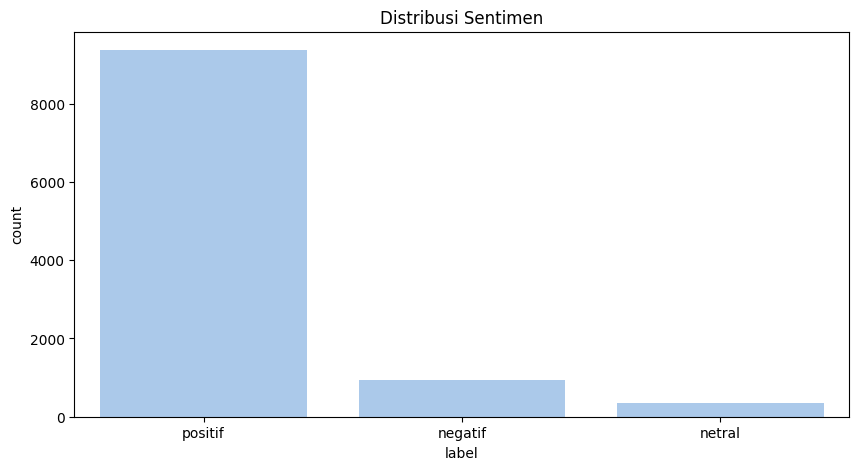

In [22]:
# liat distribusi label
sns.set_palette('pastel')
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=dt)
plt.title('Distribusi Sentimen')
plt.show()

In [23]:
# melakukan oversampling menggunakan smote
X = padded_sequences
y = dt['score']

# inisialisasi SMOTE
smote = SMOTE(random_state=42)

# melakukan oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)
dt_resampled = pd.DataFrame(X_resampled)
dt_resampled['score'] = y_resampled

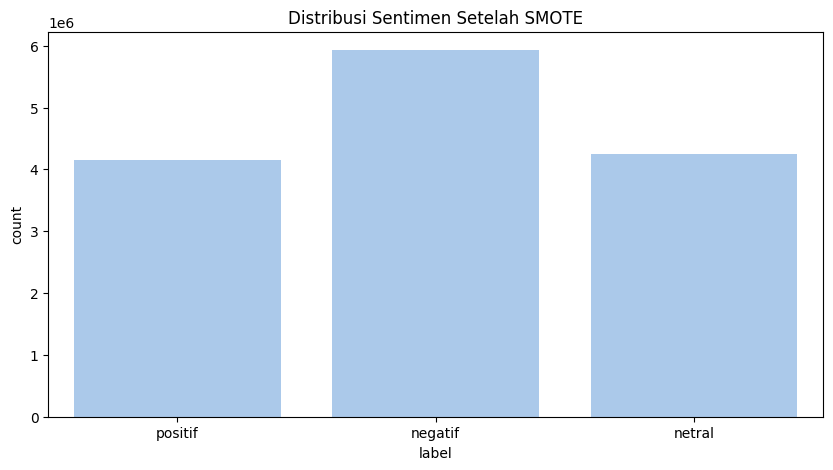

In [24]:
# cek hasil distribusi setelah SMOTE
dt_resampled['label'] = dt_resampled['score'].map(label_map)

sns.set_palette('pastel')
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=dt_resampled)
plt.title('Distribusi Sentimen Setelah SMOTE')
plt.show()

In [25]:
dt_resampled.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,score,label
0,1,2,11,109,16,4,342,0,0,0,...,0,0,0,0,0,0,0,0,2,positif
1,129,927,31,360,2721,187,5,361,766,2722,...,0,0,0,0,0,0,0,0,0,negatif
2,4,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,positif
3,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,positif
4,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,positif


In [26]:
dt_resampled['label'].value_counts()

,count
label,
positif,9372
negatif,9372
netral,9372


In [27]:
# Pisahkan data berdasarkan sentimen
data_negatif = dt[dt['label'] == 'negatif']
data_netral = dt[dt['label'] == 'netral']
data_positif = dt[dt['label'] == 'positif']

# Fungsi untuk membuat dan menampilkan wordcloud
def plot_wordcloud(data, title):
    data['normalized_content'] = data['normalized_content'].fillna('').astype(str)
    all_words = ' '.join(data['normalized_content'])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()

<ipython-input-27-63d82d10b401>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normalized_content'] = data['normalized_content'].fillna('').astype(str)


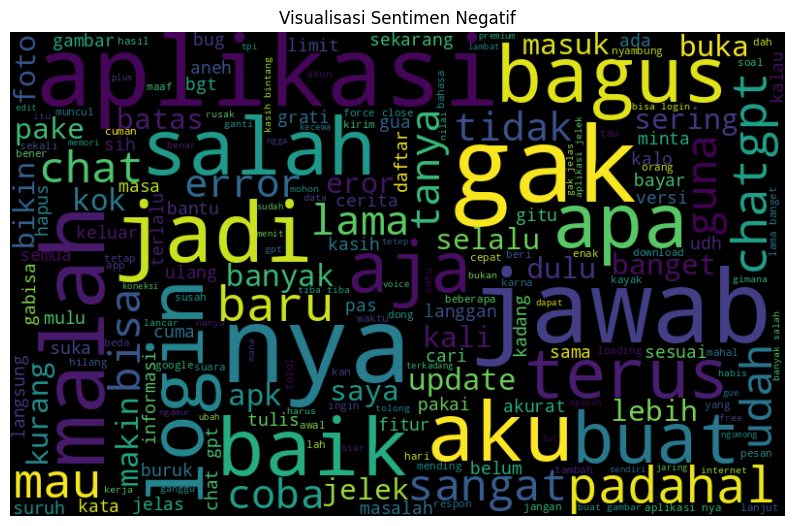

In [28]:
# wordcloud untuk sentimen negatif
plot_wordcloud(data_negatif, 'Visualisasi Sentimen Negatif')

<ipython-input-27-63d82d10b401>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normalized_content'] = data['normalized_content'].fillna('').astype(str)


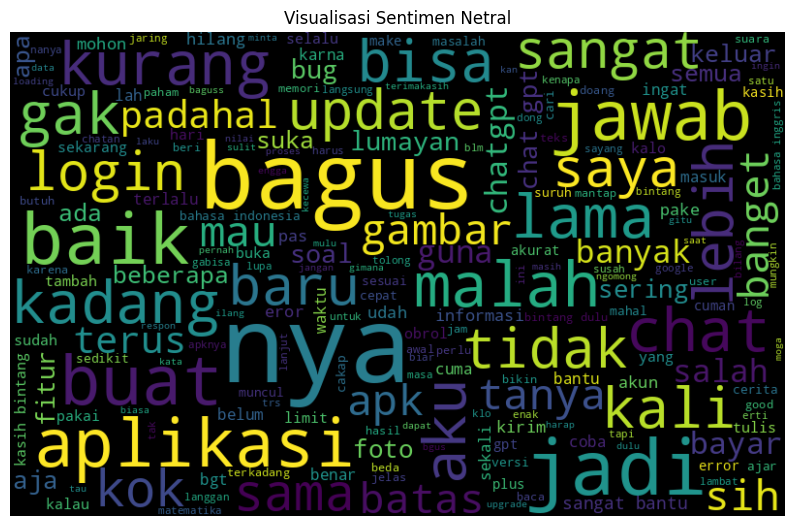

In [29]:
# wordcloud untuk sentimen netral
plot_wordcloud(data_netral, 'Visualisasi Sentimen Netral')

<ipython-input-27-63d82d10b401>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normalized_content'] = data['normalized_content'].fillna('').astype(str)


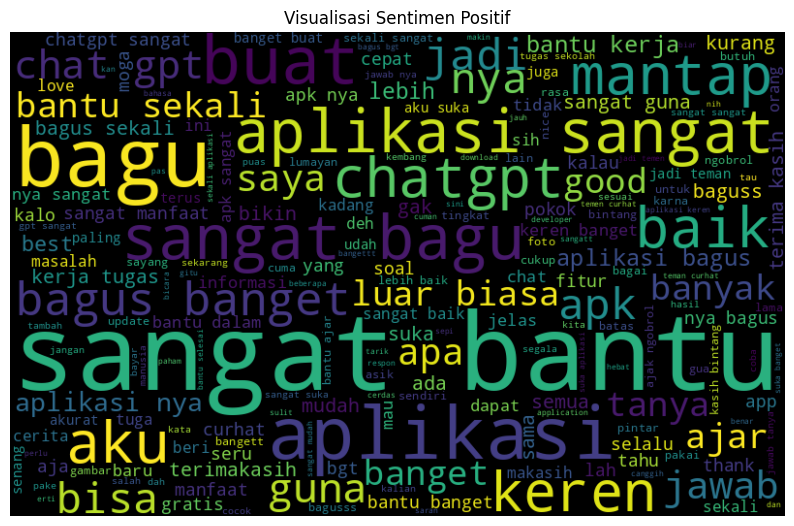

In [30]:
# wordcloud untuk sentimen positif
plot_wordcloud(data_positif, 'Visualisasi Sentimen Positif')

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# split data
X_train, X_test, y_train, y_test = train_test_split(
    dt_resampled.drop(['score', 'label'], axis=1),
    dt_resampled['score'],
    test_size=0.2,
    random_state=42
)

# model svm
svm = SVC()
svm.fit(X_train, y_train)

# prediksi
y_pred_svm = svm.predict(X_test)

# evaluasi
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM, 80/20): {accuracy_svm:.2f}")
print(classification_report(y_test, y_pred_svm))

Accuracy (SVM, 80/20): 0.57
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      1887
           1       0.62      0.53      0.57      1904
           2       0.50      0.66      0.57      1833

    accuracy                           0.57      5624
   macro avg       0.58      0.57      0.57      5624
weighted avg       0.58      0.57      0.57      5624



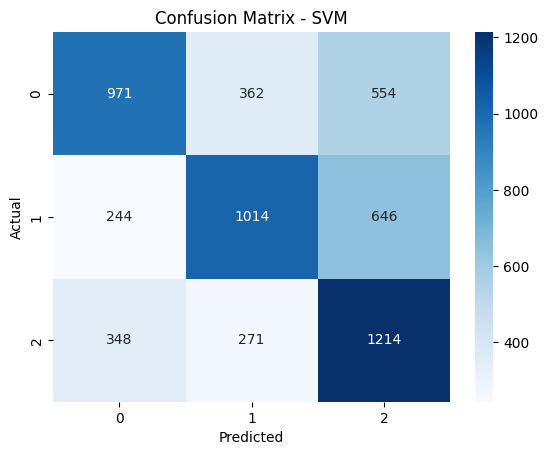

In [32]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier

# model rf
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# prediksi
y_pred_rf = rf.predict(X_test)

# evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (RF, 80/20): {accuracy_rf:.2f}")
print(classification_report(y_test, y_pred_rf))

Accuracy (RF, 80/20): 0.89
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      1887
           1       0.93      0.94      0.93      1904
           2       0.89      0.80      0.84      1833

    accuracy                           0.89      5624
   macro avg       0.89      0.89      0.89      5624
weighted avg       0.89      0.89      0.89      5624



Text(50.722222222222214, 0.5, 'Actual')

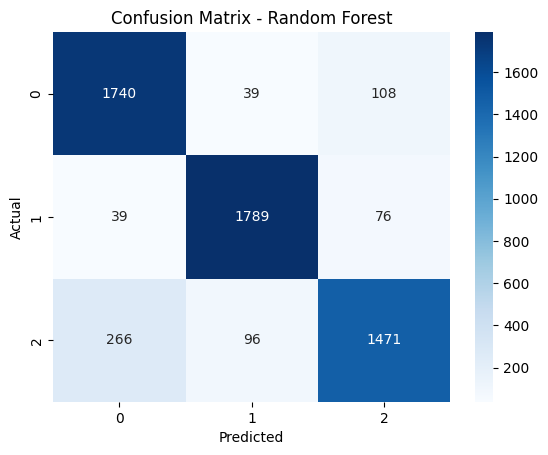

In [34]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [35]:
from sklearn.tree import DecisionTreeClassifier

# model decisionTree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# prediksi
y_pred_dt = dt.predict(X_test)

# evaluasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy (DT, 80/20): {accuracy_dt:.2f}")
print(classification_report(y_test, y_pred_dt))

Accuracy (DT, 80/20): 0.81
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1887
           1       0.83      0.86      0.85      1904
           2       0.80      0.76      0.78      1833

    accuracy                           0.81      5624
   macro avg       0.81      0.81      0.81      5624
weighted avg       0.81      0.81      0.81      5624



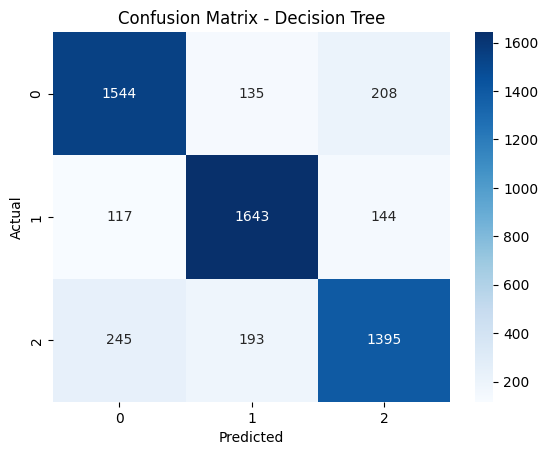

In [36]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [37]:
# model bilstm
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=50),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluasi
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 171s 458ms/step - accuracy: 0.4901 - loss: 0.9899 - val_accuracy: 0.5569 - val_loss: 0.8699
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 200s 452ms/step - accuracy: 0.5912 - loss: 0.8103 - val_accuracy: 0.5642 - val_loss: 0.8574
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 211s 478ms/step - accuracy: 0.6439 - loss: 0.7172 - val_accuracy: 0.5724 - val_loss: 0.8589
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 193s 453ms/step - accuracy: 0.7017 - loss: 0.6374 - val_accuracy: 0.5693 - val_loss: 0.9201
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 159s 452ms/step - accuracy: 0.7451 - loss: 0.5742 - val_accuracy: 0.5775 - val_loss: 0.9451
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 450ms/step - accuracy: 0.7830 - loss: 0.4967 - val_accuracy: 0.5784 - val_loss: 0.9850
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 159s 450ms/step - accuracy: 0.8200 - loss: 0.4397 - val_accuracy: 0.5827 - val_loss: 1.0092
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 211s 476ms/step - accuracy: 0.8395 -

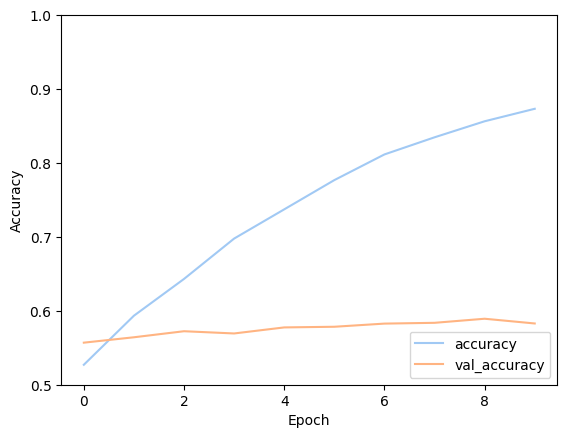

In [38]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1887
           1       0.50      0.50      0.50      1904
           2       0.77      0.76      0.76      1833

    accuracy                           0.58      5624
   macro avg       0.59      0.58      0.59      5624
weighted avg       0.58      0.58      0.58      5624



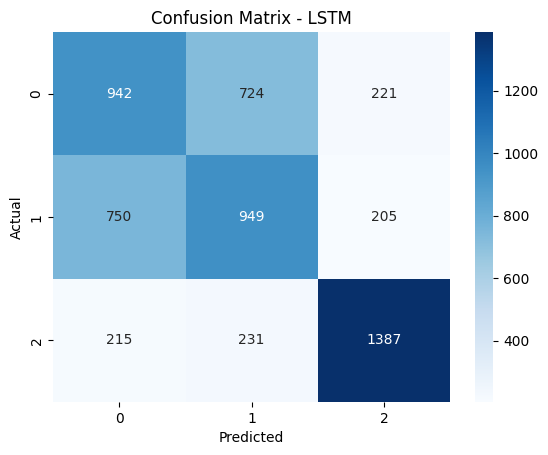

In [39]:
# buat prediksi
y_pred_lstm = model.predict(X_test)
y_pred_lstm_classes = tf.argmax(y_pred_lstm, axis=1)

# confusion matrix
print(classification_report(y_test, y_pred_lstm_classes))
cm = confusion_matrix(y_test, y_pred_lstm_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [40]:
# simmpan moden bilstm
model.save('bilstm_model.h5')

In [41]:
# Model CNN + LSTM
model_cnn_lstm = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dense(3, activation='softmax')
])

model_cnn_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

loss_cnn_lstm, accuracy_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test)
print(f"Test Loss (CNN-LSTM): {loss_cnn_lstm}")
print(f"Test Accuracy (CNN-LSTM): {accuracy_cnn_lstm}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.4495 - loss: 0.9904 - val_accuracy: 0.5571 - val_loss: 0.8019
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.6107 - loss: 0.6999 - val_accuracy: 0.5709 - val_loss: 0.7833
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.6437 - loss: 0.5842 - val_accuracy: 0.5679 - val_loss: 0.8422
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.6627 - loss: 0.5330 - val_accuracy: 0.5654 - val_loss: 0.8770
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.6789 - loss: 0.5116 - val_accuracy: 0.5633 - val_loss: 0.9957
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7224 - loss: 0.4867 - val_accuracy: 0.5809 - val_loss: 0.9205
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7825 - loss: 0.4445 - val_accuracy: 0.5848 - val_loss: 0.9624
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.8473 - loss: 0.3584 - 

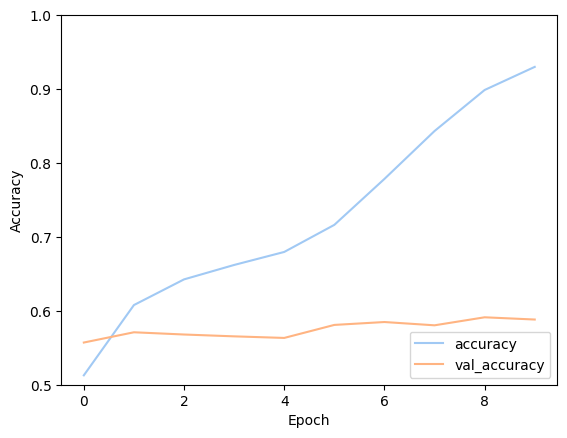

In [42]:
# Plot riwayat pelatihan untuk CNN-LSTM
plt.plot(history_cnn_lstm.history['accuracy'], label='accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
              precision    recall  f1-score   support

           0       0.48      0.57      0.52      1887
           1       0.53      0.46      0.49      1904
           2       0.79      0.74      0.76      1833

    accuracy                           0.59      5624
   macro avg       0.60      0.59      0.59      5624
weighted avg       0.60      0.59      0.59      5624



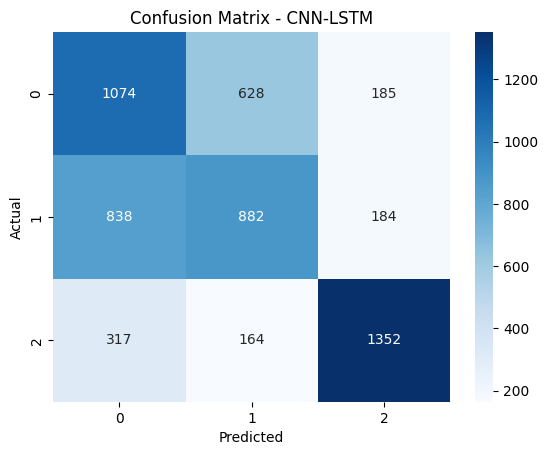

In [43]:
# Buat prediksi dengan CNN-LSTM
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)
y_pred_cnn_lstm_classes = tf.argmax(y_pred_cnn_lstm, axis=1)

# Confusi matrix CNN-LSTM
print(classification_report(y_test, y_pred_cnn_lstm_classes))
cm = confusion_matrix(y_test, y_pred_cnn_lstm_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CNN-LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [44]:
# Simpan CNN-LSTM model
model_cnn_lstm.save('cnn_lstm_model.h5')

In [47]:
# inference
# Load model
import numpy as np # Import numpy and assign it to the alias np
bilstm_model = tf.keras.models.load_model('bilstm_model.h5')
cnn_lstm_model = tf.keras.models.load_model('cnn_lstm_model.h5')

def preprocess_text(text):
    text = clean(text)
    text = normalize(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=50, padding='post', truncating='post')
    return padded_sequence

# BiLSTM
def predict_bilstm(text):
    processed_text = preprocess_text(text)
    prediction = bilstm_model.predict(processed_text)
    predicted_class = np.argmax(prediction) # Now np is defined and can be used
    label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
    return label_map[predicted_class]

# CNN-LSTM
def predict_cnn_lstm(text):
    processed_text = preprocess_text(text)
    prediction = cnn_lstm_model.predict(processed_text)
    predicted_class = np.argmax(prediction) # Now np is defined and can be used
    label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
    return label_map[predicted_class]


# (SVM, Random Forest, Decision Tree)
def predict_other_models(text, model_to_use):
    processed_text = preprocess_text(text)
    prediction = model_to_use.predict(processed_text)
    label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}

    # Menangani format keluaran prediksi
    if isinstance(prediction, np.ndarray) and prediction.ndim > 0 : # Now np is defined and can be used
      sentiment_label = label_map[prediction[0]]
    else:
      sentiment_label = label_map[prediction]

    return sentiment_label

In [48]:
user_input = input("Masukkan teks: ")
print(f"Sentimen (BiLSTM): {predict_bilstm(user_input)}")
print(f"Sentimen (CNN-LSTM): {predict_cnn_lstm(user_input)}")
print(f"Sentimen (SVM): {predict_other_models(user_input, svm)}")
print(f"Sentimen (Random Forest): {predict_other_models(user_input, rf)}")
print(f"Sentimen (Decision Tree): {predict_other_models(user_input, dt)}")

Masukkan teks: aplikasinya sangat bagus dan membantu
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Sentimen (BiLSTM): positif


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Sentimen (CNN-LSTM): positif
Sentimen (SVM): positif
Sentimen (Random Forest): positif
Sentimen (Decision Tree): positif


In [49]:
user_input = input("Masukkan teks: ")
print(f"Sentimen (BiLSTM): {predict_bilstm(user_input)}")
print(f"Sentimen (CNN-LSTM): {predict_cnn_lstm(user_input)}")
print(f"Sentimen (SVM): {predict_other_models(user_input, svm)}")
print(f"Sentimen (Random Forest): {predict_other_models(user_input, rf)}")
print(f"Sentimen (Decision Tree): {predict_other_models(user_input, dt)}")

Masukkan teks: ada batasan untuk menggunakannya tidak seperti qwen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Sentimen (BiLSTM): netral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sentimen (CNN-LSTM): negatif
Sentimen (SVM): positif
Sentimen (Random Forest): negatif
Sentimen (Decision Tree): negatif


In [50]:
user_input = input("Masukkan teks: ")
print(f"Sentimen (BiLSTM): {predict_bilstm(user_input)}")
print(f"Sentimen (CNN-LSTM): {predict_cnn_lstm(user_input)}")
print(f"Sentimen (SVM): {predict_other_models(user_input, svm)}")
print(f"Sentimen (Random Forest): {predict_other_models(user_input, rf)}")
print(f"Sentimen (Decision Tree): {predict_other_models(user_input, dt)}")

Masukkan teks: jawaban yang diberikan sering salah dan ambigu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Sentimen (BiLSTM): negatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Sentimen (CNN-LSTM): negatif
Sentimen (SVM): positif
Sentimen (Random Forest): negatif
Sentimen (Decision Tree): positif


In [51]:
%%writefile requirements.txt
pandas
seaborn
matplotlib
tensorflow
sastrawi
nltk
wordcloud
imbalanced-learn

Writing requirements.txt
